In [140]:
# inputs

#path to the .csv file created from the VeTrans output
haps = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0.csv"

#path to the Times.in file
times = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/Times.in"

#name of the protein used for plotting
protein_name = "F Protein"


"F Protein"

In [141]:
# load Julia dependencies

using CSV
using DataFrames
using RCall
using Images
using FileIO

# load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Install the devtools package if not already installed
if (!requireNamespace("devtools", quietly = TRUE))
  install.packages("devtools")

# Load the devtools package
library(devtools)

# Install ggplot2 and viridis with dependencies
install.packages(c("ggplot2", "viridis", "tidyverse"), dependencies = TRUE)

# Load the packages quietly
suppressPackageStartupMessages({
  library("ggplot2")
  library("viridis")
  library("tidyverse")
})
"""


The downloaded binary packages are in
	/var/folders/7v/htx5jcb93rvbnyr12j89csbr0000gp/T//RtmpJ94OZx/downloaded_packages


┌ Warning: RCall.jl: Installing packages into '/Users/e.smith.5/Library/R/arm64/4.4/library'
│ (as 'lib' is unspecified)
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/ggplot2_3.5.1.tgz'
│ Content type 'application/x-gzip' length 4974305 bytes (4.7 MB)
│ ==================================================
│ downloaded 4.7 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/viridis_0.6.5.tgz'
│ Content type 'application/x-gzip' length 3016921 bytes (2.9 MB)
│ ==================================================
│ downloaded 2.9 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
│ Content type 'application/x-gzip' length 428901 bytes (418 KB)
│ ==================================================
│ downloaded 418 KB
│ 
└ @ RCall /Users/e.smith.5/.julia/packages/RCall/dDAVd/src/io.jl:172


RObject{StrSxp}
 [1] "streamgraph" "lubridate"   "forcats"     "stringr"     "dplyr"      
 [6] "purrr"       "readr"       "tidyr"       "tibble"      "tidyverse"  
[11] "viridis"     "viridisLite" "ggplot2"     "devtools"    "usethis"    
[16] "stats"       "graphics"    "grDevices"   "utils"       "datasets"   
[21] "methods"     "base"       


In [142]:
# load data

haps = CSV.read(haps, DataFrame)

# pass into R
@rput haps 

R"""
library(tidyverse)

times <- colnames(haps)[-1]

haps <- haps %>%
  pivot_longer(
    cols = all_of(times),
    names_to = "Time",
    values_to = "Frequency"
  )
"""

# get back haps dataframe

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCAATAAGCAATAACAAAGG,1,0.000108336
2,GGGCCCCCAATAAGCAATAACAAAGG,29,1.0e-10
3,GGGCCCCCAATAAGCAATAACAAAGG,50,0.000272864
4,GGGCCCCCAATAAGCAATAACAAAGG,74,1.0e-10
5,GGGCCCCCAATAAGCAATAACAAAGG,83,1.0e-10
6,GGGCCCCCAATAAGCAATAACAAAGG,99,2.44527e-5
7,GGGCCCCCAATAAGCAATAACAAAGG,111,1.0e-10
8,GGGCCCCCAATAAGCAATAACAAAGG,119,1.0e-10
9,GGGCCCCCAATAAGCAATAACAAAGG,125,0.0925662


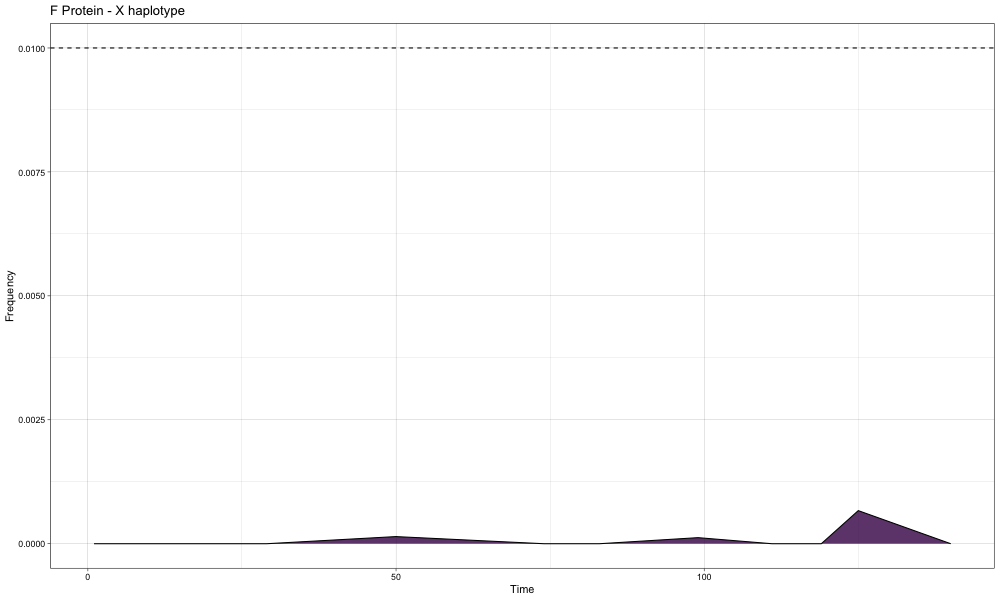

Temporary file deleted successfully.


In [143]:
# plot to check X haplotype frequencies

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""

p <- haps %>% filter(str_detect(Haplotype, "^X+$")) %>% 
    ggplot(aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
    geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
    geom_hline(yintercept = 0.01, linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = paste(protein_name, "- X haplotype"), x = "Time", y = "Frequency") +
    theme(legend.position = "none") +
    scale_fill_viridis(discrete = TRUE, direction = 1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

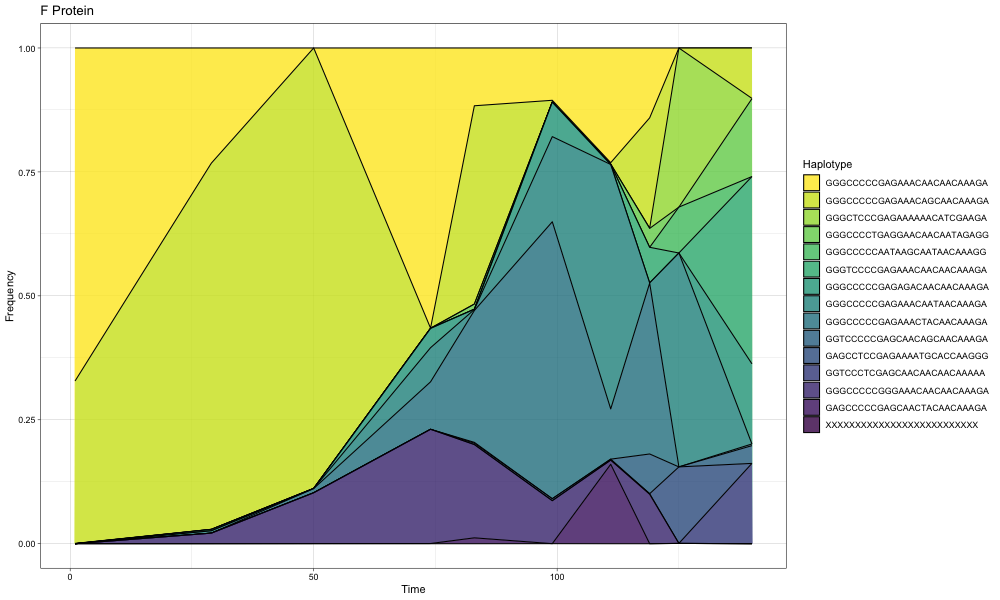

Temporary file deleted successfully.


In [144]:
# plot

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Sort haplotypes by their initial frequency
first_time_point <- haps %>% 
  filter(Time == min(Time)) %>% 
  arrange(desc(Frequency)) %>% 
  select(Haplotype, InitialFrequency = Frequency)

# Join the initial frequency data back to the main dataset
haps <- haps %>% 
  left_join(first_time_point, by = "Haplotype") %>%
  arrange(desc(InitialFrequency), Time, Frequency)

# Create a color palette with the same number of colors as unique haplotypes
num_haplotypes <- length(unique(haps$Haplotype))
haplotype_colors <- viridis::viridis(num_haplotypes, direction = -1)

# Assign colors based on the order of haplotypes by InitialFrequency
haps$Haplotype <- factor(haps$Haplotype, levels = unique(haps$Haplotype))

# Create the plot
p <- ggplot(haps, aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
  geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
  theme_linedraw() +
  labs(title = protein_name, x = "Time", y = "Frequency") +
  theme(legend.position = "right") +
  scale_fill_manual(values = haplotype_colors)


png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [145]:
using DataFrames
using CSV

# Function to find the consensus haplotype at the minimum time point
function consensus_haplotype(df::DataFrame)
    # Find the minimum time point
    min_time = minimum(df[!, :Time])
    
    # Filter the dataframe for the minimum time point
    filtered_df = filter(row -> row.Time == min_time, df)
    
    # Group by haplotype and sum their frequencies
    grouped_df = combine(groupby(filtered_df, :Haplotype), :Frequency => sum)
    
    # Find the haplotype with the maximum summed frequency
    max_freq_row = grouped_df[argmax(grouped_df[!, :Frequency_sum]), :]
    
    return max_freq_row.Haplotype
end

# Call the function and get the consensus haplotype
consensus = consensus_haplotype(haps)
println("The consensus haplotype at the first time point is: $consensus")

The consensus haplotype at the first time point is: GGGCCCCCGAGAAACAACAACAAAGA


In [146]:
# Function to calculate mismatches
function count_mismatches(haplotype::String, consensus::String)::Union{Int, String}
    mismatches = 0
    for i in 1:length(haplotype)
        if haplotype[i] != consensus[i]
            mismatches += 1
        end
    end
    if mismatches == length(haplotype)
        return "X"
    else
        return mismatches
    end
end

# Add new column with mismatch count
haps.Mismatches = [count_mismatches(row.Haplotype, consensus) for row in eachrow(haps)]

println(haps)

# Group the DataFrame by the 'Mismatches' column
@rput haps
R"""
# Grouping by Time and Mismatches, then summing Frequency
haps_mismatched <- haps %>%
    group_by(Time, Mismatches) %>%
    summarize(Frequency = sum(Frequency), .groups = 'drop')
"""

@rget haps_mismatched

150×4 DataFrame
 Row │ Haplotype                   Time    Frequency    Mismatches 
     │ String                      String  Float64      Any        
─────┼─────────────────────────────────────────────────────────────
   1 │ GGGCCCCCAATAAGCAATAACAAAGG  1       0.000108336  5
   2 │ GGGCCCCCAATAAGCAATAACAAAGG  29      1.0e-10      5
   3 │ GGGCCCCCAATAAGCAATAACAAAGG  50      0.000272864  5
   4 │ GGGCCCCCAATAAGCAATAACAAAGG  74      1.0e-10      5
   5 │ GGGCCCCCAATAAGCAATAACAAAGG  83      1.0e-10      5
   6 │ GGGCCCCCAATAAGCAATAACAAAGG  99      2.44527e-5   5
   7 │ GGGCCCCCAATAAGCAATAACAAAGG  111     1.0e-10      5
   8 │ GGGCCCCCAATAAGCAATAACAAAGG  119     1.0e-10      5
   9 │ GGGCCCCCAATAAGCAATAACAAAGG  125     0.0925662    5
  10 │ GGGCCCCCAATAAGCAATAACAAAGG  140     1.0e-10      5
  11 │ GGGTCCCCGAGAAACAACAACAAAGA  1       1.0e-10      1
  12 │ GGGTCCCCGAGAAACAACAACAAAGA  29      0.00278285   1
  13 │ GGGTCCCCGAGAAACAACAACAAAGA  50      1.00249e-10  1
  14 │ GGGTCCCCGAGAAACAACA

Row,Time,Mismatches,Frequency
,String,Any,Float64
1,1,5,0.000288598
2,1,1,0.327615
3,1,3,2.0e-10
4,1,8,1.0e-10
5,1,4,0.000337723
6,1,0,0.671759
7,1,X,1.0e-10
8,111,5,0.000839678
9,111,1,0.605561


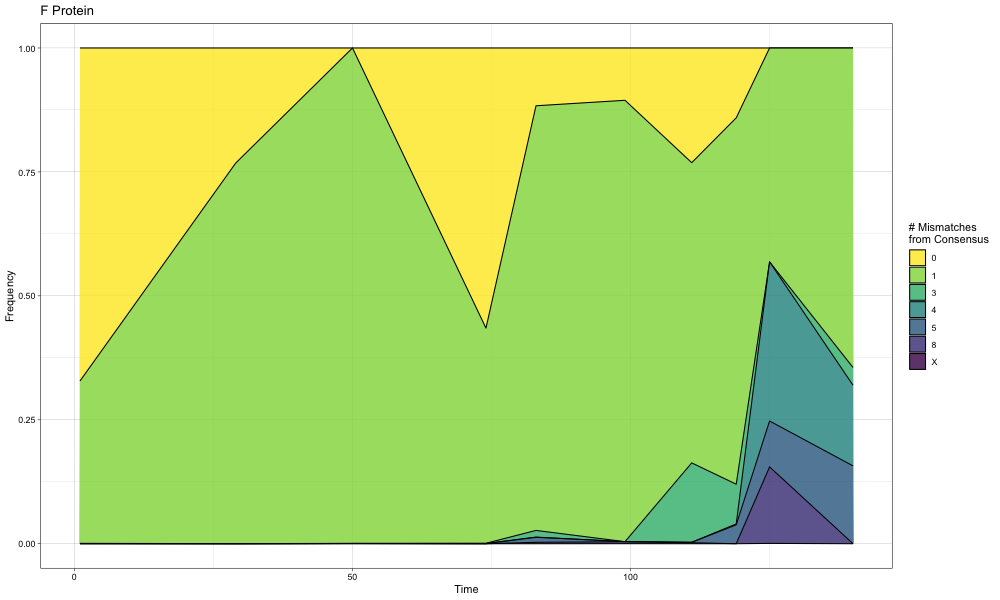

Temporary file deleted successfully.


In [147]:
# area plot for counts of mutations
# plot

@rput haps_mismatched # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Ensure columns are of correct types
haps_mismatched$Frequency <- as.numeric(unlist(haps_mismatched$Frequency))
haps_mismatched$Mismatches <- as.factor(as.character(unlist(haps_mismatched$Mismatches)))
haps_mismatched$Time <- as.numeric(unlist(haps_mismatched$Time))

p <- haps_mismatched %>% arrange(desc(Time)) %>% 
    ggplot(aes(x = as.numeric(Time), y = Frequency, fill = as.factor(Mismatches))) + 
    geom_area(alpha = 0.8 , linewidth = 0.5, colour = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency", fill = "# Mismatches\nfrom Consensus") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
img = load(output_path)
display(img)

  
# Delete the temporary image file after displaying
rm(output_path; force = true)
println("Temporary file deleted successfully.")
else

println("File does not exist.")

end